In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install layoutparser[ocr] torchvision && pip install "git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install pdf2image
!apt-get install poppler-utils

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-install-0li25izg/detectron2_b8569e57b4a04bde9e723f67f53a3546
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-0li25izg/detectron2_b8569e57b4a04bde9e723f67f53a3546
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  Resolved https://github.com/facebookresearch/detectron2.git to commit 82a57ce0b70057685962b352535147d9a8118578
  Preparing metadata (setup.py) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import os
import layoutparser as lp
import cv2
from pdf2image import convert_from_path
import spacy
import numpy as np

In [ ]:
def preprocess_image(image):
    """Convert image to grayscale, binarize it, and convert back to BGR."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_bgr = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    return binary_bgr

In [ ]:
def convert_pdf_folder_to_images(input_folder, output_folder):
    """Convert all PDFs in the input folder to images and save in the output folder, omitting the last page."""
    for filename in os.listdir(input_folder):
        if filename.endswith(".pdf"):
            pdf_path = os.path.join(input_folder, filename)
            # Convert the entire PDF to images
            images = convert_from_path(pdf_path)
            # Process all pages except the last one
            for i in range(len(images) - 1):  # Subtract 1 to omit the last page
                image_np = np.array(images[i])  # Convert PIL image to numpy array
                processed_image = preprocess_image(image_np)

                # Define output path
                base_filename = filename[:-4]  # Remove '.pdf' from filename
                output_path = os.path.join(output_folder, f"{base_filename}_page_{i}.jpg")

                # Save the preprocessed image
                cv2.imwrite(output_path, processed_image)

# Set the input and output directories
input_folder = '/content/drive/MyDrive/dataset'
output_folder = '/content/drive/MyDrive/images'

# Ensure output directory exists
os.makedirs(output_folder, exist_ok=True)

# Process all PDFs in the input folder
convert_pdf_folder_to_images(input_folder, output_folder)

In [ ]:
model = lp.models.Detectron2LayoutModel('lp://HJDataset/mask_rcnn_R_50_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={1:"Page Frame", 2:"Row", 3:"Title Region", 4:"Text Region", 5:"Title", 6:"Subtitle", 7:"Other"})

config.yml?dl=1: 8.19kB [00:02, 3.36kB/s]
model_final.pth?dl=1: 351MB [00:19, 18.4MB/s]                           
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [ ]:
def load_image(image_path):
    # Using OpenCV to load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"No file found at {image_path}")
    return image

In [ ]:
def process_all_images_in_folder(folder_path):
    """Process all JPEG images in the specified folder."""
    # List all files in the given folder
    layouts = []
    for filename in os.listdir('/content/drive/MyDrive/images'):
        if filename.lower().endswith(".jpg"):  # Check for JPEG files
            full_path = os.path.join(folder_path, filename)
            try:
                doc_id = filename.split('_')[0]
                year = filename.split('_')[1]
                # Load the image
                image = load_image(full_path)
                # Process the image
                result = model.detect(image)
                layouts.append({"doc_id": doc_id, "year": year, "layout": result, "image": image})
            except Exception as e:
                print(f"Failed to process {filename}: {str(e)}")
    return layouts

In [ ]:
layouts = process_all_images_in_folder('/content/drive/MyDrive/images')

In [ ]:
len(layouts)

473

In [ ]:
def ensure_directory_exists(file_path):
    """Ensure the directory for the given file path exists; if not, create it."""
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory, exist_ok=True)

In [ ]:
from PIL import Image

for i in range(len(layouts):
    image_with_boxes = lp.draw_box(
        canvas=layouts[i]['image'],  # Image data
        layout=layouts[i]['layout'],  # Layout blocks data
        box_width=3,
        color_map={
            "Page Frame": "red",
            "Row": "orange",
            "Title Region": "yellow",
            "Text Region": "green",
            "Title": "blue",
            "Subtitle": "purple",
            "Other": "brown"
        },
        show_element_type=True
    )

    # Save the image with boxes
    doc_id = layouts[i]['doc_id']
    year = layouts[i]['year']
    output_path = f'/content/drive/MyDrive/outputs/{doc_id}_{year}_{i}.jpg'  # Specify your desired output path
    ensure_directory_exists(output_path)
    image_with_boxes.save(output_path)

    print(f"Image saved to {output_path}")

Image saved to /content/drive/MyDrive/outputs/SC5106470029_1962_0.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106465093_1954_1.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106465093_1954_2.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106465093_1954_3.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464161_1957_4.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_5.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_6.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_7.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_8.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_9.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_10.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_11.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_12.jpg
Image saved to /content/drive/MyDrive/outputs/SC5106464508_1951_13.jpg
Image saved to /

In [ ]:
page_frames = 0
rows = 0
title_regions = 0
text_regions = 0
titles = 0
subtitles = 0
others = 0
for layout in layouts:
    for block in layout["layout"]._blocks:
        if block.type == 'Page Frame':
            page_frames += 1
        elif block.type == 'Row':
            rows += 1
        elif block.type == 'Title Region':
            title_regions += 1
        elif block.type == 'Text Region':
            text_regions += 1
        elif block.type == 'Title':
            titles += 1
        elif block.type == 'Subtitle':
            subtitles += 1
        else:
            others += 1

In [ ]:
ocr_preprocess = []
for layout in layouts:
    image = layout['image']
    blocks = lp.Layout([b for b in layout['layout']])
    ocr_preprocess.append((image, blocks))

In [ ]:
page_frames, rows, title_regions, text_regions, titles, subtitles, others

(358, 823, 50, 3, 9, 4, 133)

In [ ]:
ocr_agent = lp.GCVAgent.with_credential("/content/ec2355-final-project-0759caab7e72.json",
                                       languages = ['en'])

In [ ]:
ocr_results = []

# Assuming `image` is your original image and `table_blocks` contains detected table regions
for doc in ocr_preprocess:
    for block in doc[1]:
        # Get bounding box coordinates
        x1, y1, x2, y2 = [int(i) for i in block.coordinates]
        block.pad(left=10, right=10, top=10, bottom=10, safe_mode=True)
        # Crop the table region from the image
        table_image = doc[0][y1:y2, x1:x2]
        text = ocr_agent.detect(table_image, return_response=True)
        block.set(text=text, inplace=True)
        # Optionally, save or display the cropped table image
        ocr_results.append((table_image, text))

In [ ]:
final_ocr_results = []
for ocr_result in ocr_results:
    res = ocr_agent.detect(ocr_result[0], return_response=True)
    texts  = ocr_agent.gather_text_annotations(res)
    layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.WORD)
    final_ocr_results.append((res, texts, layout))

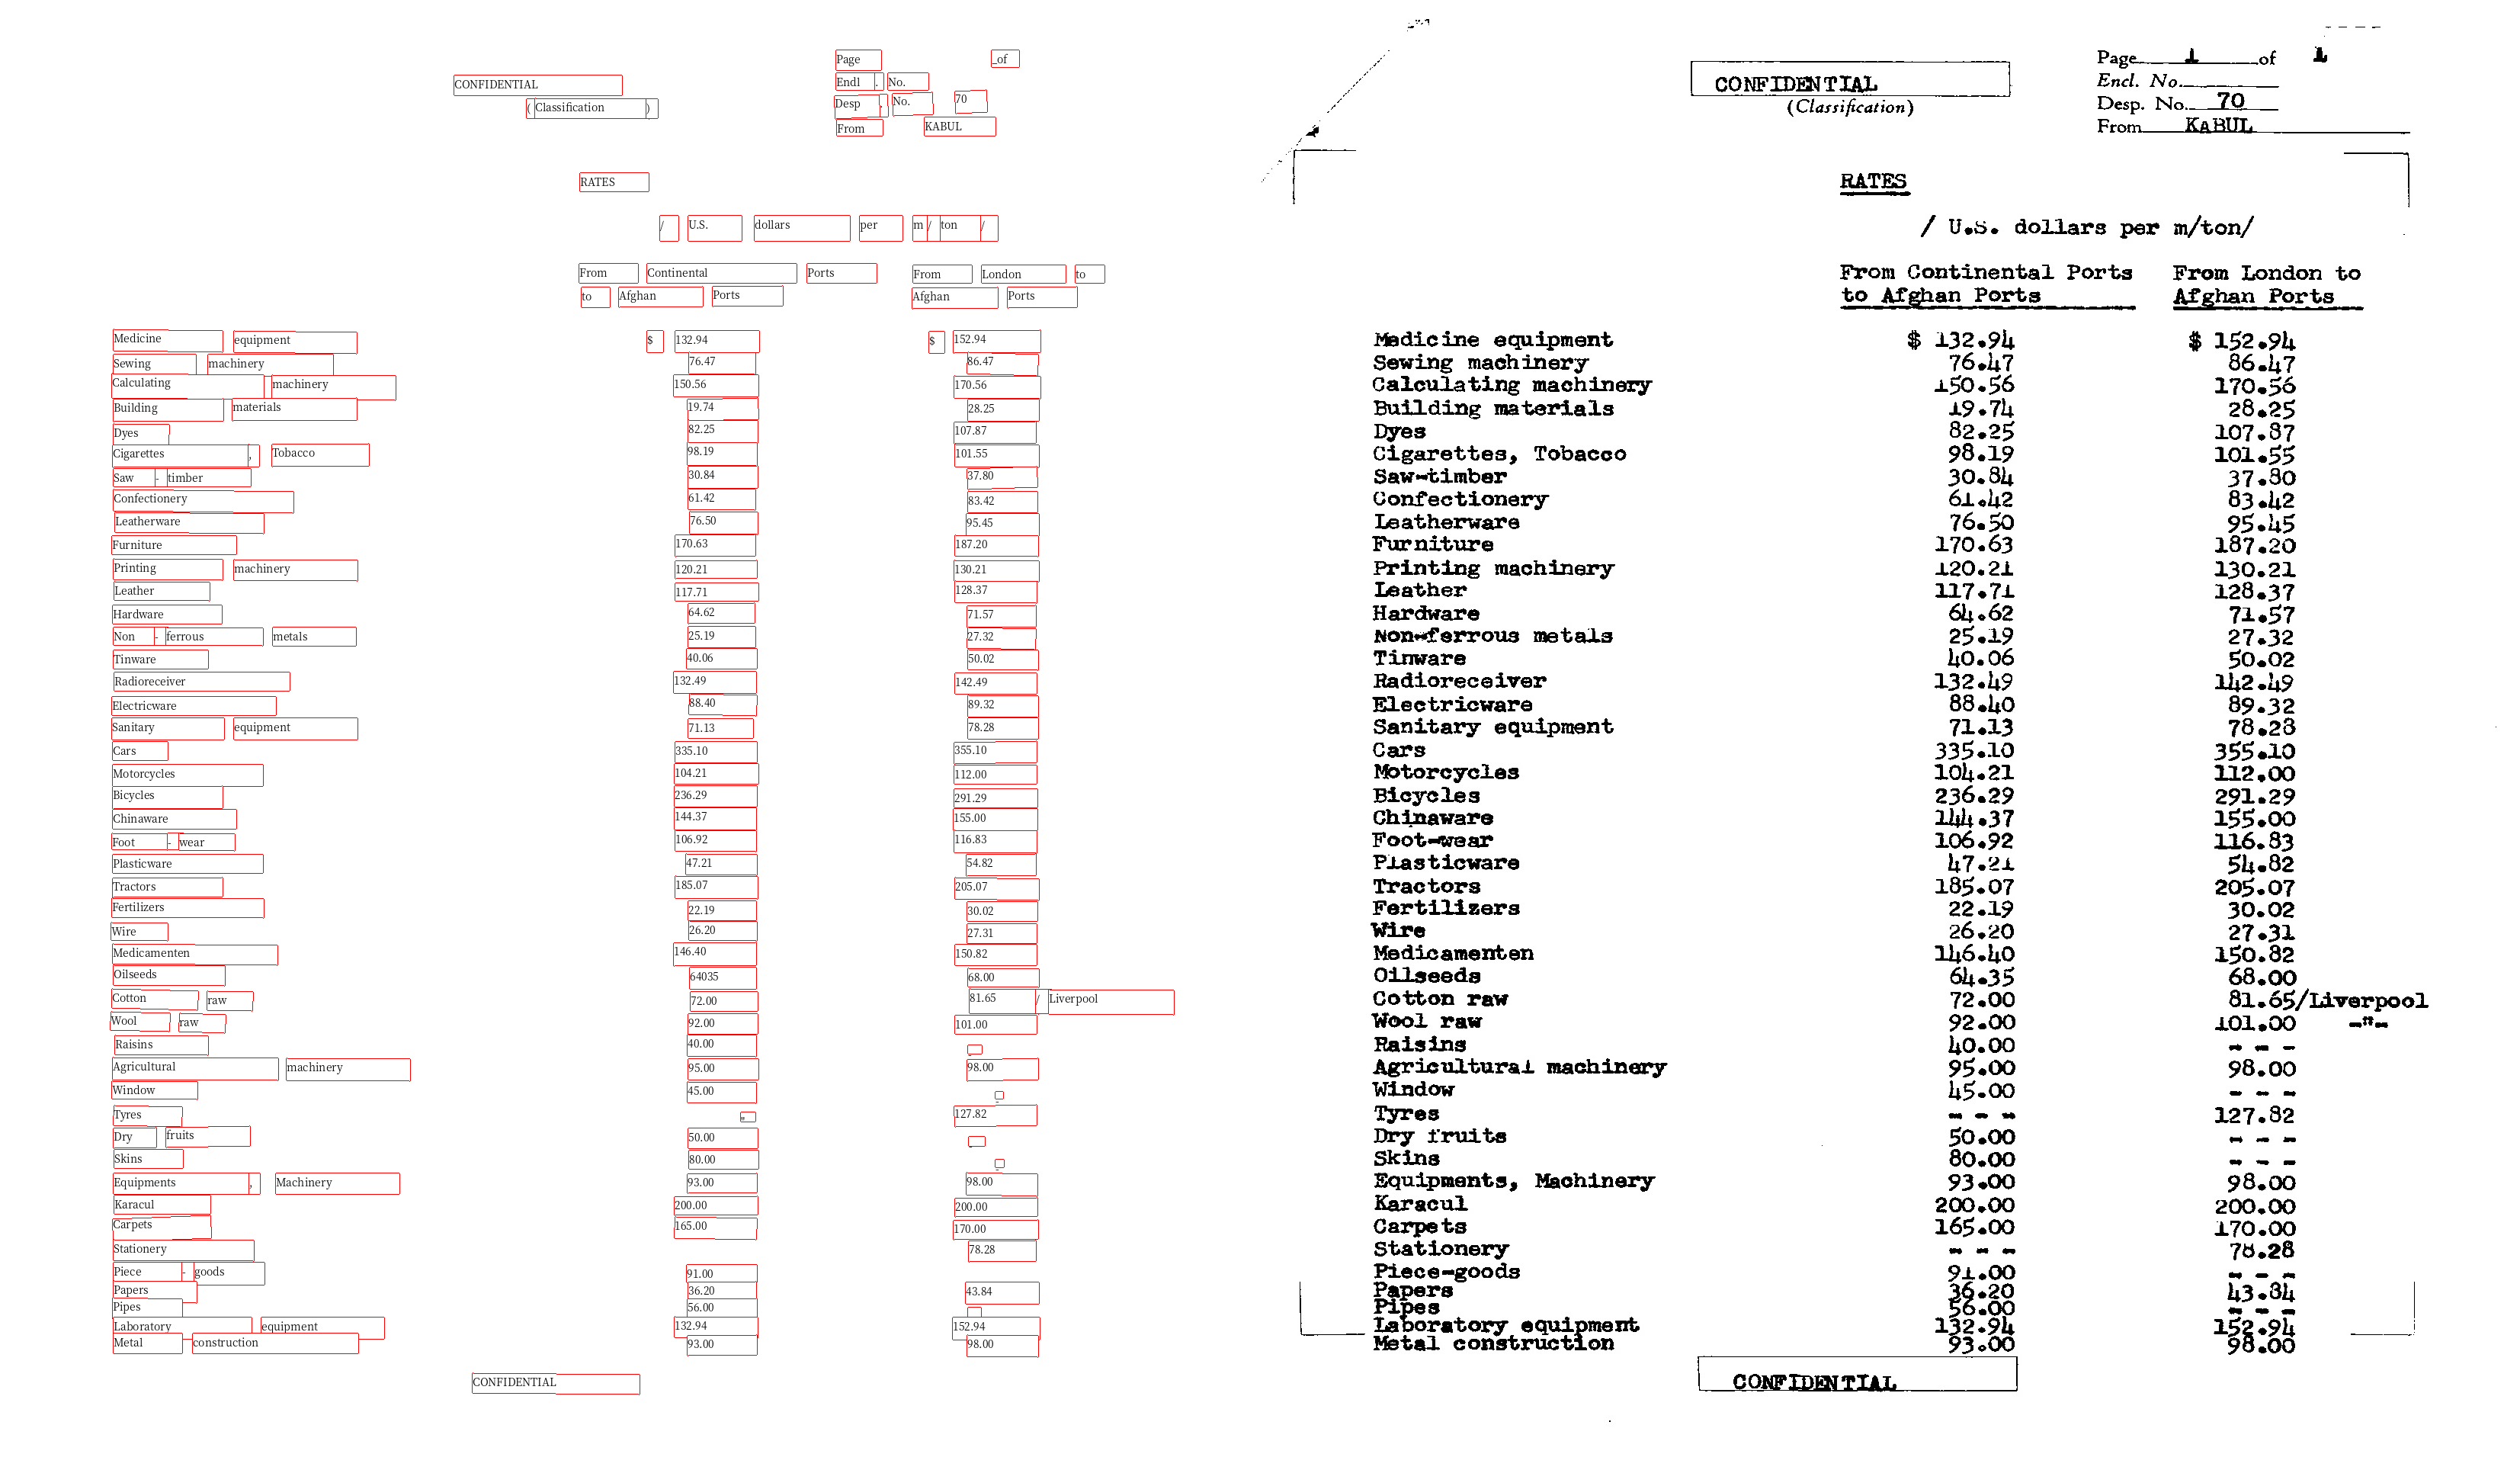

In [ ]:
# lp.draw_text(image, layout, font_size=14, with_box_on_text=True, text_box_width=3)

In [ ]:
final_ocr_results[0]

(text_annotations {
   locale: "en"
   description: "Philippine Government policy still is not i\nSoviet Union and Soviet bloc countries. How\ned imports come from Soviet bloc countries i\ncountries. Official foreign trade statisti\nsy information reveal no foreign trade betwe\npines and Russia after World War II."
   bounding_poly {
     vertices {
       y: 4
     }
     vertices {
       x: 720
       y: 4
     }
     vertices {
       x: 720
       y: 166
     }
     vertices {
       y: 166
     }
   }
 }
 text_annotations {
   description: "Philippine"
   bounding_poly {
     vertices {
       x: 9
       y: 4
     }
     vertices {
       x: 176
       y: 4
     }
     vertices {
       x: 176
       y: 30
     }
     vertices {
       x: 9
       y: 30
     }
   }
 }
 text_annotations {
   description: "Government"
   bounding_poly {
     vertices {
       x: 195
       y: 4
     }
     vertices {
       x: 362
       y: 4
     }
     vertices {
       x: 362
       y: 30
     

In [ ]:
extracted_texts = []
for final_ocr_result in final_ocr_results:
    extract = [a.text for a in final_ocr_result[1]]
    full_extr_texts = " ".join(extract)
    extracted_texts.append(full_extr_texts)

In [ ]:
extracted_texts_all = " ".join(extracted_texts)

In [ ]:
extracted_texts_all

'Philippine Government policy still is not i Soviet Union and Soviet bloc countries . How ed imports come from Soviet bloc countries i countries . Official foreign trade statisti sy information reveal no foreign trade betwe pines and Russia after World War II .  4 ) franc zone exporters to the Soviet Union will henceforth benefit i EFAC account systen presently in effect with regard to exports to most tries subject to the regulations of the Office Marocain des Changes . reas the percentage to be set apart in favor of the exporters to the Se n is not stipulated in this notification , it is believed that it will i ercent of the value of the exportation in cases of firm sale and 6 per ⚫ept . Only REC D E4 12/6 I 1 00 / 8-2 NEAY ELUR - 5 . 2-2 Rep - 2 hist F OTHER ° 。 Com - 10 FA - 10 Cia - 6 TR - 3 TAR - L OST - 2 FRB ET : D - 12 : French Moroccan Commercial Quotas - Soviet Union Cirmy - 4 Navy -3 ais 3 ag - 7 A bilateral commercial agreement , covering the period from July 15 , 1954 , De

In [ ]:
# Load the pre-trained NER model
nlp = spacy.load("en_core_web_sm")

# Apply the model
doc = nlp(extracted_texts_all)
entities = []

# Print entities in the text
for ent in doc.ents:
    print(ent.text, ent.label_)
    entities.append((ent.text, ent.label_))


Streaming output truncated to the last 5000 lines.
two CARDINAL
two CARDINAL
Livi ORG
Milan GPE
two days ago DATE
May 20th DATE
Dave PERSON
Houston GPE
May 6 DATE
Coptic Christian NORP
the United States GPE
Davis PERSON
six CARDINAL
Special Edition of Al Gomhouria WORK_OF_ART
May 2 1957 DATE
Egyptian NORP
Al Gomhouria PERSON
the past year DATE
Egyptian NORP
1957 DATE
859 CARDINAL
Attala PERSON
LE 1,000 ORG
Egyptian NORP
Aden GPE
the United States GPE
1,000 CARDINAL
Attala PERSON
between $ 1,600- $ 1,800 MONEY
approximately $ 2,870 MONEY
at least 20 percent PERCENT
American NORP
more than three CARDINAL
Attala PERSON
the United States - Egyptian GPE
Gua PERSON
May 3-7 , 1955 DATE
Attala PERSON
Cairo GPE
USIA ORG
Lutfi Atalla PERSON
the Farajalla Press Agency ORG
Time- Life - Fortune ORG
Embassy ORG
February 26 DATE
American NORP
Egypt GPE
American NORP
American NORP
English LANGUAGE
French NORP
Arabic LANGUAGE
the Soviet Union GPE
483 CARDINAL
803 CARDINAL
WASHINGTON GPE
RM GPE
February

In [ ]:
from collections import defaultdict

# Organize entities by type
grouped_entities = defaultdict(list)
for text, label in entities:
    grouped_entities[label].append(text)

# Now `grouped_entities` has all texts grouped by their labels
for label, texts in grouped_entities.items():
    print(f"{label}: {texts[1:100]}")
    print(f"{label}: {len(texts)}")

ORG: ['Philippine Government', 'EFAC', 'the Office Marocain des Changes', 'Cia', 'Quotas - Soviet Union Cirmy - 4 Navy', 'Meat Citrus', 'Meat Citrus', 'the American Bureau of Shipping', 'KIRK D M', 'Sov Union', 'State', 'BERLIN', 'SENT', 'BERLIN', 'Sov Union', 'the Stat Planning Commission', 'Ourtel', 'Interzonal Trade Agreement', 'Formation', 'EASTERN', 'BERLIN', 'THE DEPARTMENT OF STATE', '-DR', 'the State lanning Commission', 'Ourtel', 'w', 'Interzonal Trade Agreement', 'Di A', 'coke', 'ge', 'fac', 'Huettenkombinat', 'ge', 'the Taegliche Rundschau', 'the State Planning Commission', 'nego', 'nego', 'the State Planning Commission', 'Eastern', 'the U Government', 'Commerce', 'the Comprehensive Export Schedule', 'BFC', 'Research for Drilling Techniques', 'the Comprehensive Export Schedule', 'the U.S. Government', 'BFC', 'Christensen Diamond Products Co.', 'Commerce', 'BFC', 'Research for Drilling Techniques', 'Scientific & Technical Div', 'RCTompos', 'Export Policy Staff', 'State Dept',

In [ ]:
grouped_entities.keys()

dict_keys(['ORG', 'GPE', 'NORP', 'EVENT', 'MONEY', 'PERSON', 'CARDINAL', 'DATE', 'PRODUCT', 'LOC', 'QUANTITY', 'FAC', 'ORDINAL', 'TIME', 'WORK_OF_ART', 'LAW', 'PERCENT', 'LANGUAGE'])